# Model Notebook

NoteBook for our Age & Gender Detector. We will be extracting the data, train our model, fit it and then optimize is for better results.

## Import the necessary libraries

In [6]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, RMSprop

## Extracting data from the dataset

Download the datasets from [here](https://www.kaggle.com/datasets/jangedoo/utkface-new)

In [7]:
filedr = "./UTKFace"

In [8]:
import os
files = os.listdir(filedr)

## Populating list of image from the dataset

In [9]:
ages = []
genders = []
images = []

for fl in files:
    age = int(fl.split('_')[0])
    gender = int(fl.split('_')[1])
    filename = filedr + '/' + fl
    #print(filename)

    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (48, 48))
    images.append(image)

## Populating list of Age and Gender from the dataset

In [10]:
for fl in files:
    age = int(fl.split('_')[0])
    gender = int(fl.split('_')[1])
    
    ages.append(age)
    genders.append(gender)

## Viewing a sample from our imported dataset

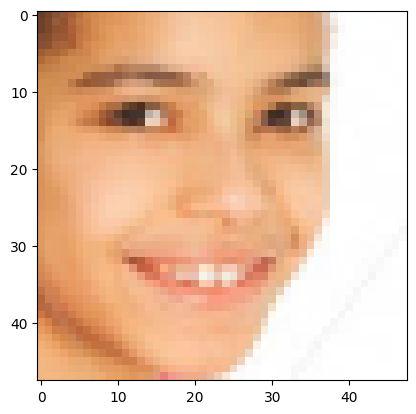

In [11]:
plt.imshow(images[88])

In [12]:
print("Age: {}, Gender: {}".format(ages[88], genders[88]))

Age: 10, Gender: 0


## Saving ages array, genders array and images array in the system

In [13]:
ages_f = np.array(ages)
genders_f = np.array(genders)
images_f = np.array(images)

In [14]:
np.save(filedr + "image.npy", images_f)
np.save(filedr + "gender.npy", genders_f)
np.save(filedr + "age.npy", ages_f)

## Counting the number of males and females samples respectively

In [15]:
values, counts = np.unique(genders_f, return_counts = True)
print(counts)

[12391 11317]


## Plotting the number of Male and Female samples

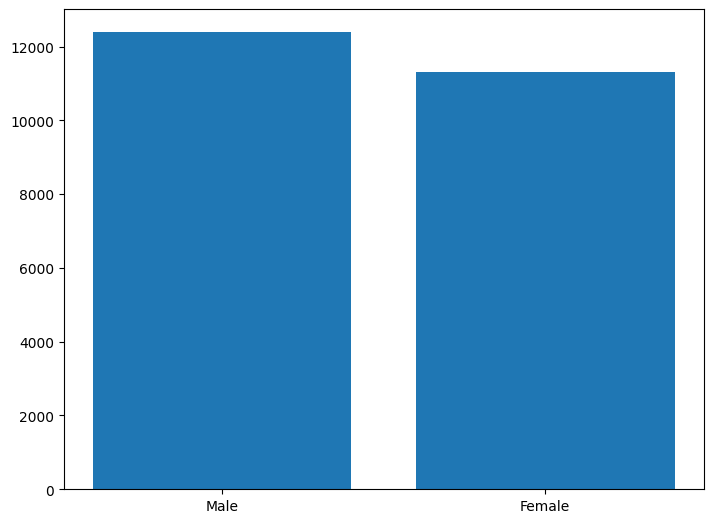

In [16]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
gender = ["Male", "Female"]
values = counts
ax.bar(gender, values)
plt.show()

## Counting the number of samples for each age

In [17]:
values, counts = np.unique(ages_f, return_counts = True)
print(counts)

[1123  482  289  273  196  131  139  263  166  156   65  130   81  157
  177  247  158  262   98  284  346  395  426  859  734 2197  615  918
  570  724  350  664  143  409  880  483  293  325  266  526  132  266
  157  100  440  153  170  153  148  381  138  232  241  353  268  236
   97  271   82  293  161  125  103   50  259   77   94  100   56  147
   33   98   63   32  148   58   28   69   23  133   22   40   18   24
  155   35   10   34   33   82    2   13    5    9   17    9   11    2
    1    5    5    1    3    4]


## Converting Age counts to list

In [18]:
val = values.tolist()
cnt = counts.tolist()

## Plotting the samples Agewise

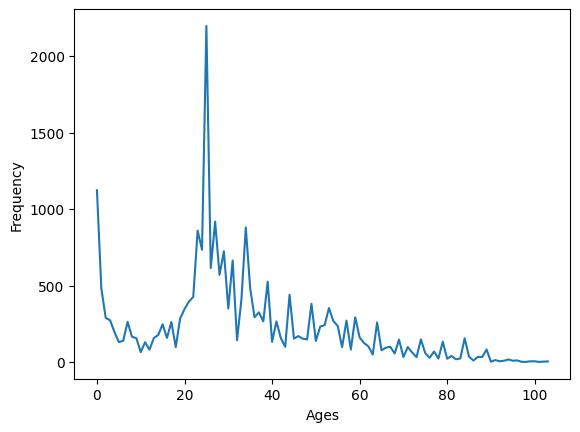

In [19]:
plt.plot(counts)
plt.xlabel('Ages')
plt.ylabel('Frequency')
plt.show()

## Defining Labels for output

In [20]:
labels = []
i = 0
while i < len(ages):
    label = []
    label.append(ages[i])
    label.append(genders[i])

    labels.append(label)
    i = i + 1

## Creating simplified image list for better learning of our model

In [21]:
images_f_2 = images_f/255
images_f_2.shape

(23708, 48, 48, 3)

In [22]:
labels_f = np.array(labels)

## Splitting dataset into train and test

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(images_f_2, labels_f, test_size=0.25)

In [25]:
Y_train[0:6]

array([[45,  0],
       [31,  0],
       [37,  0],
       [24,  1],
       [31,  0],
       [23,  1]])

## Splitting the 'Y_train' & 'Y_test' further for better analysis

In [26]:
Y_train_2 = [Y_train[:, 1], Y_train[:, 0]]
Y_test_2 = [Y_test[:, 1], Y_test[:, 0]]

In [27]:
Y_train_2[0][0:6]

array([0, 0, 0, 1, 0, 1])

In [28]:
Y_train_2[1][0:6]

array([45, 31, 37, 24, 31, 23])

## Defining the model

In [29]:
def Convolution(input_tensor, filters):
    x = Conv2D(filters = filters, kernel_size = (3, 3), padding = "same", strides = (1, 1), kernel_regularizer = l2(0.001))(input_tensor)
    x = Dropout(0.1)(x)
    x = Activation('relu')(x)

    return x

In [30]:
def model(input_shape):
    inputs = Input((input_shape))

    ## Convolutional Layers & MaxPool Layers
    conv_1 = Convolution(inputs, 32)
    maxp_1 = MaxPooling2D(pool_size = (2, 2))(conv_1)
    conv_2 = Convolution(maxp_1, 64)
    maxp_2 = MaxPooling2D(pool_size = (2, 2))(conv_2)
    conv_3 = Convolution(maxp_2, 128)
    maxp_3 = MaxPooling2D(pool_size = (2, 2))(conv_3)
    conv_4 = Convolution(maxp_3, 256)
    maxp_4 = MaxPooling2D(pool_size = (2, 2))(conv_4)

    ## 3D matrix into 1D vector
    flatten = Flatten()(maxp_4)

    dense_1 = Dense(64, activation = 'relu')(flatten)
    dense_2 = Dense(64, activation = 'relu')(flatten)

    drop_1 = Dropout(0.2)(dense_1)
    drop_2 = Dropout(0.2)(dense_2)

    output_1 = Dense(1, activation = 'sigmoid', name = 'sex-out')(drop_1)
    output_2 = Dense(1, activation = 'relu', name = 'age-out')(drop_2)

    model = Model(inputs = [inputs], outputs = [output_1, output_2])
    model.compile(loss = ["binary_crossentropy", "mae"], optimizer = "Adam", metrics = ["accuracy"])

    return model

In [31]:
Model = model((48, 48, 3))

In [32]:
Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 32)           896       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 48, 48, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 activation (Activation)     (None, 48, 48, 32)           0         ['dropout[0][0]']             
                                                                                              

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint

## Initializing the Model

In [34]:
file_s = "Age_Sex_Detector.h5"
checkpoint = ModelCheckpoint(file_s, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
Early_stop = tf.keras.callbacks.EarlyStopping(patience = 75, monitor = 'val_loss', restore_best_weights = 'True')
callback_list = [checkpoint, Early_stop]

## Running the Model
### Time taking process

In [35]:
History = Model.fit(X_train, Y_train_2, batch_size=64, validation_data=(X_test, Y_test_2), epochs=250, callbacks=callback_list) 

Epoch 1/250
278/278 [==============================] - ETA: 0s - loss: 16.6119 - sex-out_loss: 0.6939 - age-out_loss: 15.7286 - sex-out_accuracy: 0.5463 - age-out_accuracy: 0.0475
Epoch 1: val_loss improved from inf to 17.57811, saving model to Age_Sex_Detector.h5
278/278 [==============================] - 45s 158ms/step - loss: 16.6119 - sex-out_loss: 0.6939 - age-out_loss: 15.7286 - sex-out_accuracy: 0.5463 - age-out_accuracy: 0.0475 - val_loss: 17.5781 - val_sex-out_loss: 0.6576 - val_age-out_loss: 16.7406 - val_sex-out_accuracy: 0.5917 - val_age-out_accuracy: 0.0466
Epoch 2/250
  1/278 [..............................] - ETA: 36s - loss: 14.7001 - sex-out_loss: 0.6681 - age-out_loss: 13.8521 - sex-out_accuracy: 0.5781 - age-out_accuracy: 0.0000e+00

c:\Users\bru80\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


278/278 [==============================] - ETA: 0s - loss: 13.1712 - sex-out_loss: 0.5974 - age-out_loss: 12.3591 - sex-out_accuracy: 0.6855 - age-out_accuracy: 0.0472
Epoch 2: val_loss improved from 17.57811 to 16.00875, saving model to Age_Sex_Detector.h5
278/278 [==============================] - 43s 155ms/step - loss: 13.1712 - sex-out_loss: 0.5974 - age-out_loss: 12.3591 - sex-out_accuracy: 0.6855 - age-out_accuracy: 0.0472 - val_loss: 16.0088 - val_sex-out_loss: 0.5831 - val_age-out_loss: 15.1766 - val_sex-out_accuracy: 0.7176 - val_age-out_accuracy: 0.0375
Epoch 3/250
278/278 [==============================] - ETA: 0s - loss: 11.0850 - sex-out_loss: 0.5155 - age-out_loss: 10.3030 - sex-out_accuracy: 0.7491 - age-out_accuracy: 0.0443
Epoch 3: val_loss improved from 16.00875 to 13.09773, saving model to Age_Sex_Detector.h5
278/278 [==============================] - 43s 154ms/step - loss: 11.0850 - sex-out_loss: 0.5155 - age-out_loss: 10.3030 - sex-out_accuracy: 0.7491 - age-out_ac

## Model Evaluation

In [36]:
Model.evaluate(X_test, Y_test_2)

186/186 [==============================] - 3s 14ms/step - loss: 7.4042 - sex-out_loss: 0.2747 - age-out_loss: 6.3382 - sex-out_accuracy: 0.8881 - age-out_accuracy: 0.0466


[7.404211521148682,
 0.27474531531333923,
 6.338156700134277,
 0.888139009475708,
 0.04656656086444855]

In [37]:
pred = Model.predict(X_test)

186/186 [==============================] - 3s 12ms/step


In [38]:
pred[1]

array([[22.741016 ],
       [ 6.1968617],
       [36.9054   ],
       ...,
       [ 3.62939  ],
       [25.438526 ],
       [31.27021  ]], dtype=float32)

## Plotting Loss

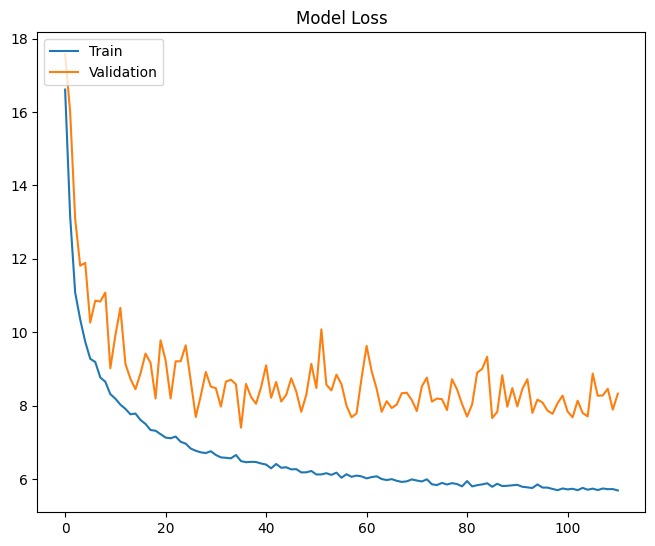

In [39]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.xlabel = ('Epoch')
plt.ylabel = ('Loss')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0, hspace = 0.25, wspace = 0.35)

## Plotting Sex Accuracy

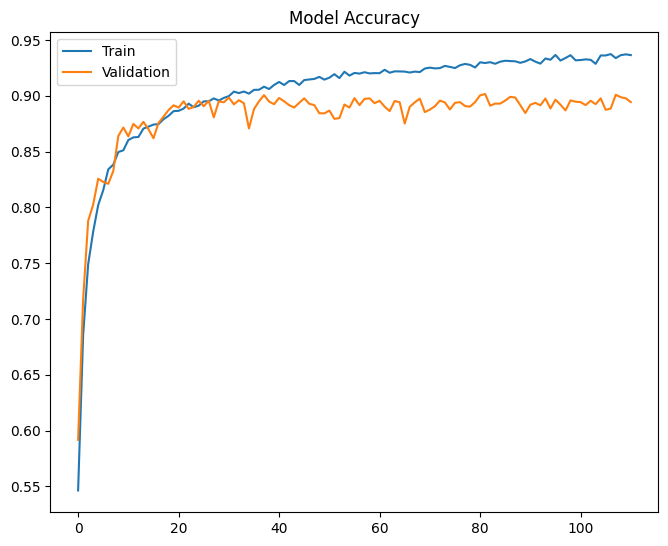

In [40]:
plt.plot(History.history['sex-out_accuracy'])
plt.plot(History.history['val_sex-out_accuracy'])
plt.title('Model Accuracy')
plt.xlabel = ('Epoch')
plt.ylabel = ('Accuracy')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0, hspace = 0.25, wspace = 0.35)

## Plotting Age Accuracy

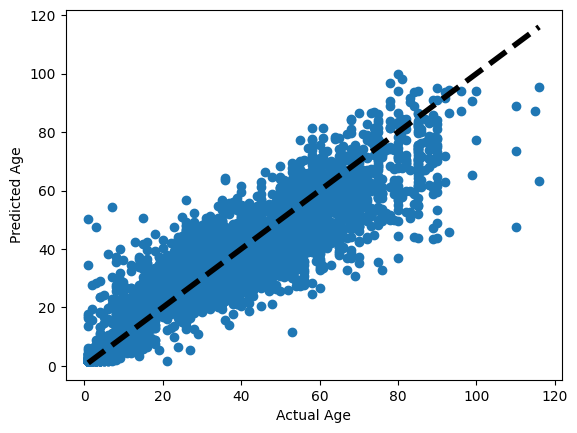

In [41]:
fig,ax = plt.subplots()
ax.scatter(Y_test_2[1], pred[1])
ax.plot([Y_test_2[1].min(), Y_test_2[1].max()], [Y_test_2[1].min(), Y_test_2[1].max()], 'k--',lw = 4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age')
plt.show()

## Making Report of the Model(Gender Only)

In [42]:
i = 0
Pred_l = []
while i < len(pred[0]):
    Pred_l.append(int(np.round(pred[0][i])))
    i += 1

In [43]:
from sklearn.metrics import confusion_matrix, classification_report

In [44]:
report = classification_report(Y_test_2[0], Pred_l)

In [45]:
print(report)

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3129
           1       0.91      0.84      0.88      2798

    accuracy                           0.89      5927
   macro avg       0.89      0.89      0.89      5927
weighted avg       0.89      0.89      0.89      5927



## Making HeatMap of the Model(Gender Only)

In [46]:
results = confusion_matrix(Y_test_2[0], Pred_l)

<Axes: >

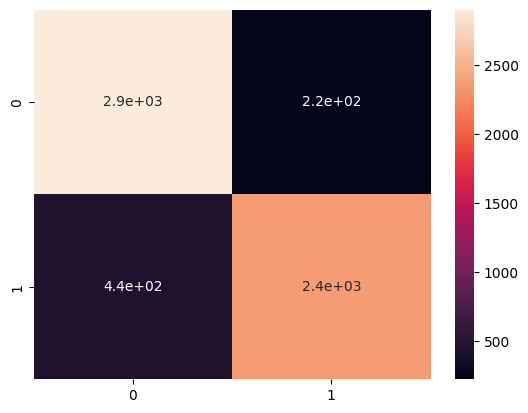

In [47]:
import seaborn as sns
sns.heatmap(results, annot = True)

## Testing the images by ourself

In [48]:
def test_image(ind, images_f, images_f_2, Model):
    plt.imshow(images_f[ind])
    image_test = images_f_2[ind]
    pred_l = Model.predict(np.array([image_test]))
    sex_f = ['Male', 'Female']
    age = int(np.round(pred_l[1][0]))
    sex = int(np.round(pred_l[0][0]))
    print("Predicted Age is " + str(age))
    print("Predicted Gender is " + sex_f[sex])

## Test #1

1/1 [==============================] - 0s 16ms/step
Predicted Age is 94
Predicted Gender is Female


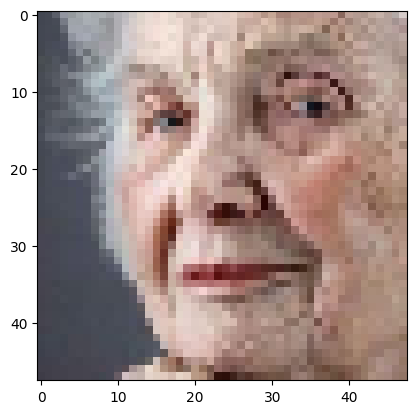

In [56]:
test_image(4, images_f, images_f_2, Model)

## Test #2

1/1 [==============================] - 0s 22ms/step
Predicted Age is 8
Predicted Gender is Male


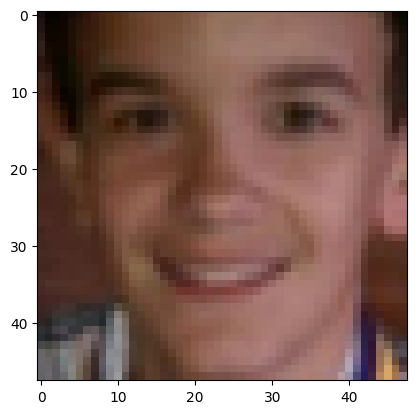

In [60]:
test_image(23, images_f, images_f_2, Model)

## Test #3

1/1 [==============================] - 0s 17ms/step
Predicted Age is 17
Predicted Gender is Female


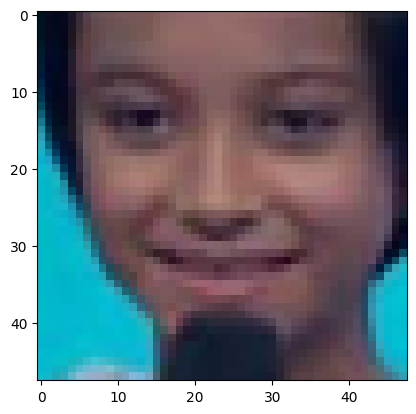

In [51]:
test_image(168, images_f, images_f_2, Model)

## Test #4

1/1 [==============================] - 0s 15ms/step
Predicted Age is 18
Predicted Gender is Male


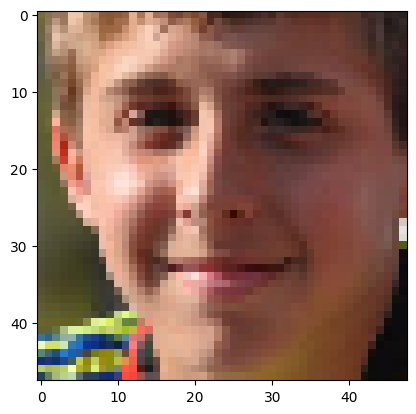

In [52]:
test_image(888, images_f, images_f_2, Model)

## Test #5

1/1 [==============================] - 0s 17ms/step
Predicted Age is 26
Predicted Gender is Female


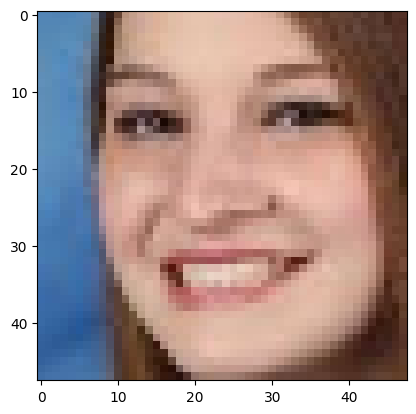

In [53]:
test_image(1288, images_f, images_f_2, Model)